# 19기 KNN 정규세션 과제

## KNN 구현해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. KNN 구현 & 파라미터 튜닝
수업 내용 및 실습 자료를 참고하여 KNN을 구현하고 파라미터 튜닝을 하며 결과를 비교해주세요.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [565]:
import pandas as pd
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


In [566]:
df.info()
#product_category2,3에 결측값이 존재한다. 
#product_category_1을 종속변수로 knn클러스터링을 구현해보자. 
#catergory_1,2,user_id,product_id는 사용하지 않도록 하겠다. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


# product_category1

In [567]:
df['Product_Category_1'].value_counts()
#1부터 20으로 분류되어있다. 

5     1407
1     1285
8      995
2      227
11     206
3      193
6      193
4      107
16      78
15      57
13      43
10      41
7       40
12      31
20      31
19      20
14      19
18      18
17       6
9        1
Name: Product_Category_1, dtype: int64

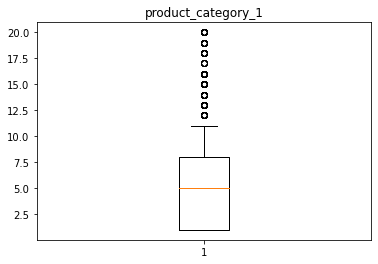

In [568]:
#boxplot을 그리자
import matplotlib.pyplot as plt
plt.boxplot(df['Product_Category_1'],whis=0.5)
plt.title('product_category_1')
plt.show()
#이상치가 몇개 있는듯 하다 

In [569]:
def outliers_iqr(dt,col): #이상치를 구하는 함수 
  quartile_1,quartile_3=np.percentile(dt[col],[25,75])
  iqr=quartile_3-quartile_1
  lower_whis=quartile_1-(iqr*0.8)
  upper_whis=quartile_3+(iqr*0.8)
  outliers=dt[(dt[col]>upper_whis)|(dt[col]<lower_whis)]
  return outliers


In [570]:
import numpy as np
out=outliers_iqr(df,'Product_Category_1')
df.loc[out.index,"Product_Category_1"]=None
df['Product_Category_1']=df['Product_Category_1'].dropna()

In [571]:
df['Product_Category_1'].value_counts()
#정제가 된 것을 확인할 수 있다. 1~13까지의 변수 존재 

5.0     1407
1.0     1285
8.0      995
2.0      227
11.0     206
3.0      193
6.0      193
4.0      107
13.0      43
10.0      41
7.0       40
12.0      31
9.0        1
Name: Product_Category_1, dtype: int64

# gender

In [572]:
df["Gender"].value_counts() #이상치 없음 

M    3765
F    1233
Name: Gender, dtype: int64

# age

In [573]:
df["Age"].value_counts()
#나이 범위간격이 들쑥날쑥이다. 
#0~17,18~25,26~35,36~45,46~55,55+로 만들어주자 

26-35    1996
36-45    1000
18-25     906
46-50     414
51-55     350
55+       195
0-17      137
Name: Age, dtype: int64

In [574]:
df=df.replace('46-50','46-55')
df=df.replace('51-55','46-55')


In [575]:
df['Age'].value_counts() #합쳐진 상태로 잘 표현되었다. 

26-35    1996
36-45    1000
18-25     906
46-55     764
55+       195
0-17      137
Name: Age, dtype: int64

In [576]:
#나이별 카테고리의 분포를 확인해보자. 둘다 범주형 변수이므로 막대그래프를 그리자 
def df_(data_make,column,want_list):
    final_df=pd.DataFrame()
    for i in want_list:
        datamake=data_make[(data_make[column]==i)]
        datayn=datamake['Product_Category_1'].value_counts()
        datayn=datayn.to_frame()
        datayn=datayn.rename(columns={'Product_Category_1':i})
        datayn=datayn.transpose()
        datayn.columns=sorted(datayn.columns)
        final_df=pd.concat([final_df,datayn],axis=0)
        final_df=final_df.fillna(0)
    return final_df
    

In [577]:
data1=df[['Age','Product_Category_1']]
final_df=df_(data1,'Age',['0-17','18-25','26-35','36-45','46-55','55+'])

print(final_df)
    
 

       1.0   2.0   3.0   4.0   5.0   7.0   8.0   10.0  11.0  12.0  6.0   13.0  \
0-17     35    32    23    15     9   7.0     4     2     2     1   0.0   0.0   
18-25   270   228   152    61    44  31.0    22     6     5     5  40.0   5.0   
26-35   578   532   395    95    82  67.0    35    18    15    13  80.0   7.0   
36-45   275   253   207    54    45  29.0    24     8     8     4  29.0   1.0   
46-55   197   192   164    33    29  22.0    19    12     9     7  28.0   6.0   
55+      60    54    40     7     5   0.0     5     4     3     2   5.0   1.0   

       9.0   
0-17    0.0  
18-25   0.0  
26-35   0.0  
36-45  12.0  
46-55   0.0  
55+     0.0  


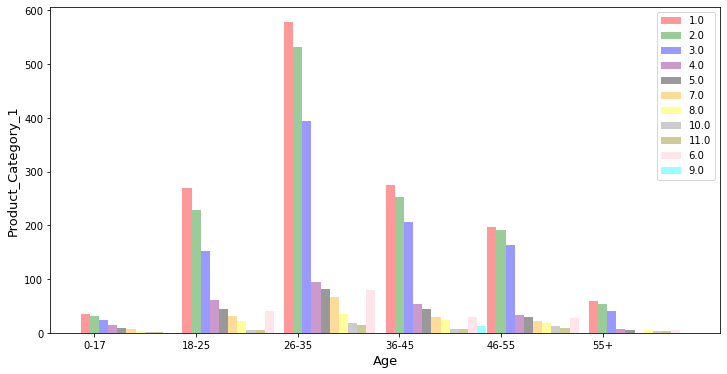

In [578]:
fig,ax=plt.subplots(figsize=(12,6))
bar_width=0.09
index=np.arange(6)

b1=plt.bar(index,final_df[1.0],bar_width,alpha=0.4,color='red',label='1.0')
b2=plt.bar(index+bar_width,final_df[2.0],bar_width,alpha=0.4,color='green',label='2.0')
b3=plt.bar(index+bar_width*2,final_df[3.0],bar_width,alpha=0.4,color='blue',label='3.0')
b4=plt.bar(index+bar_width*3,final_df[4.0],bar_width,alpha=0.4,color='purple',label='4.0')
b5=plt.bar(index+bar_width*4,final_df[5.0],bar_width,alpha=0.4,color='black',label='5.0')
b6=plt.bar(index+bar_width*5,final_df[7.0],bar_width,alpha=0.4,color='orange',label='7.0')
b7=plt.bar(index+bar_width*6,final_df[8.0],bar_width,alpha=0.4,color='yellow',label='8.0')
b8=plt.bar(index+bar_width*7,final_df[10.0],bar_width,alpha=0.4,color='gray',label='10.0')
b9=plt.bar(index+bar_width*8,final_df[11.0],bar_width,alpha=0.4,color='olive',label='11.0')
b10=plt.bar(index+bar_width*9,final_df[6.0],bar_width,alpha=0.4,color='pink',label='6.0')
b11=plt.bar(index+bar_width*10,final_df[9.0],bar_width,alpha=0.4,color='cyan',label='9.0')

plt.xticks(np.arange(bar_width,6+bar_width,1),['0-17','18-25','26-35','36-45','46-55','55+'])
plt.xlabel('Age',size=13)
plt.ylabel('Product_Category_1',size=13)
plt.legend()
plt.show()
#연령대별 전체 수에 따라 개수차이가 크지만 공통적으로 
#1,2,3,4그룹의 순서대로 많이 묶임. 
#18-25,36-45그룹에서 4,5번이 상대적으로 많다. 

# occupation

In [579]:
df['Occupation'].value_counts()
#직업인듯한데,,이미 숫자형으로 바뀌어있어서 개입해서 전처리할 수가 없다...무슨 직업인지 알수가 없다. 
#이 범주형변수를 원핫인코딩하면 너무 많은 칼럼이 생성될 것이므로 줄이는 전처리를 하자
#숫자로 표시된 범주형 자료이므로 상자그림으로 이상치 제거는 무의미하다. 

4     706
0     572
7     535
1     460
17    339
12    305
20    285
2     251
14    245
16    244
6     186
3     160
15    133
10    122
5      98
11     95
19     73
13     65
18     56
9      50
8      18
Name: Occupation, dtype: int64

In [580]:
#개수가 160개 미만인 자료를 없애자. 
outliers=df[(df['Occupation']==8)|(df['Occupation']==9)|(df['Occupation']==18)|(df['Occupation']==13)|(df['Occupation']==19)|
           (df['Occupation']==11)|(df['Occupation']==5)|(df['Occupation']==10)|(df['Occupation']==15)]
df.loc[outliers.index,'Occupation']=None
df['Occupation']=df['Occupation'].dropna()

In [581]:
df['Occupation'].value_counts()

4.0     706
0.0     572
7.0     535
1.0     460
17.0    339
12.0    305
20.0    285
2.0     251
14.0    245
16.0    244
6.0     186
3.0     160
Name: Occupation, dtype: int64

# City_Category

In [582]:
df['City_Category'].value_counts()
#살고 있는 도시 

B    2102
C    1555
A    1341
Name: City_Category, dtype: int64

In [583]:
data2=df[['City_Category','Product_Category_1']]
final_df=df_(data2,'City_Category',['A','B','C'])
print(final_df)

   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  11.0  12.0  \
A   418   331   263    62    54    51    38    30  10.0    10     9     9   
B   584   502   435   100    98    94    70    51   0.0    18    18    17   
C   452   405   297    73    61    61    57    26   0.0    16    14    12   

   13.0  
A     1  
B    15  
C     7  


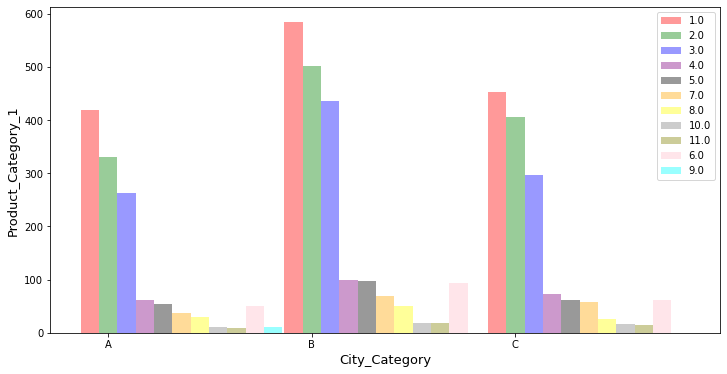

In [584]:
fig,ax=plt.subplots(figsize=(12,6))
bar_width=0.09
index=np.arange(3)

b1=plt.bar(index,final_df[1.0],bar_width,alpha=0.4,color='red',label='1.0')
b2=plt.bar(index+bar_width,final_df[2.0],bar_width,alpha=0.4,color='green',label='2.0')
b3=plt.bar(index+bar_width*2,final_df[3.0],bar_width,alpha=0.4,color='blue',label='3.0')
b4=plt.bar(index+bar_width*3,final_df[4.0],bar_width,alpha=0.4,color='purple',label='4.0')
b5=plt.bar(index+bar_width*4,final_df[5.0],bar_width,alpha=0.4,color='black',label='5.0')
b6=plt.bar(index+bar_width*5,final_df[7.0],bar_width,alpha=0.4,color='orange',label='7.0')
b7=plt.bar(index+bar_width*6,final_df[8.0],bar_width,alpha=0.4,color='yellow',label='8.0')
b8=plt.bar(index+bar_width*7,final_df[10.0],bar_width,alpha=0.4,color='gray',label='10.0')
b9=plt.bar(index+bar_width*8,final_df[11.0],bar_width,alpha=0.4,color='olive',label='11.0')
b10=plt.bar(index+bar_width*9,final_df[6.0],bar_width,alpha=0.4,color='pink',label='6.0')
b11=plt.bar(index+bar_width*10,final_df[9.0],bar_width,alpha=0.4,color='cyan',label='9.0')

plt.xticks(np.arange(bar_width,3+bar_width,1),['A','B','C'])
plt.xlabel('City_Category',size=13)
plt.ylabel('Product_Category_1',size=13)
plt.legend()
plt.show()
#age변수와 비슷하다. 

# stay_in_current_city_years

In [585]:
df['Stay_In_Current_City_Years'].value_counts()
#도시에 산 기간 

1     1758
2      915
3      908
4+     742
0      675
Name: Stay_In_Current_City_Years, dtype: int64

In [586]:
data3=df[['Stay_In_Current_City_Years','Product_Category_1']]
final_df=df_(data3,'Stay_In_Current_City_Years',['1','2','3','4+','0'])
print(final_df)

    1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   10.0  11.0  12.0  13.0  \
1    500   446   330    79    77    74    73    34    22    17    13    11   
2    260   238   174    55    34    32    31    22     9     8     7     4   
3    251   250   174    48    37    35    32    17     7     6     5     1   
4+   199   184   172    31    29    28    24    18    10     6     4     4   
0    197   167   145    33    27    24    16    16     4     4     4     3   

    9.0   
1    0.0  
2    0.0  
3    7.0  
4+   0.0  
0    0.0  


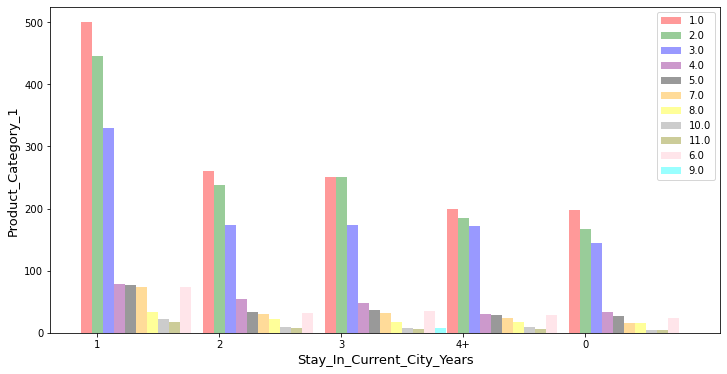

In [587]:
fig,ax=plt.subplots(figsize=(12,6))
bar_width=0.09
index=np.arange(5)

b1=plt.bar(index,final_df[1.0],bar_width,alpha=0.4,color='red',label='1.0')
b2=plt.bar(index+bar_width,final_df[2.0],bar_width,alpha=0.4,color='green',label='2.0')
b3=plt.bar(index+bar_width*2,final_df[3.0],bar_width,alpha=0.4,color='blue',label='3.0')
b4=plt.bar(index+bar_width*3,final_df[4.0],bar_width,alpha=0.4,color='purple',label='4.0')
b5=plt.bar(index+bar_width*4,final_df[5.0],bar_width,alpha=0.4,color='black',label='5.0')
b6=plt.bar(index+bar_width*5,final_df[7.0],bar_width,alpha=0.4,color='orange',label='7.0')
b7=plt.bar(index+bar_width*6,final_df[8.0],bar_width,alpha=0.4,color='yellow',label='8.0')
b8=plt.bar(index+bar_width*7,final_df[10.0],bar_width,alpha=0.4,color='gray',label='10.0')
b9=plt.bar(index+bar_width*8,final_df[11.0],bar_width,alpha=0.4,color='olive',label='11.0')
b10=plt.bar(index+bar_width*9,final_df[6.0],bar_width,alpha=0.4,color='pink',label='6.0')
b11=plt.bar(index+bar_width*10,final_df[9.0],bar_width,alpha=0.4,color='cyan',label='9.0')

plt.xticks(np.arange(bar_width,5+bar_width,1),['1','2','3','4+','0'])
plt.xlabel('Stay_In_Current_City_Years',size=13)
plt.ylabel('Product_Category_1',size=13)
plt.legend()
plt.show()

# martial_status

In [588]:
df['Marital_Status'].value_counts() #혼인여부 

0    2892
1    2106
Name: Marital_Status, dtype: int64

In [589]:
data4=df[['Marital_Status','Product_Category_1']]
final_df=df_(data4,'Marital_Status',[0,1])
print(final_df)

   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   10.0  11.0  12.0  13.0  \
0   831   744   560   132   124   117   116    58    23    22    20    18   
1   576   541   435    95    90    76    69    49    20    18    13     1   

   9.0   
0   0.0  
1  21.0  


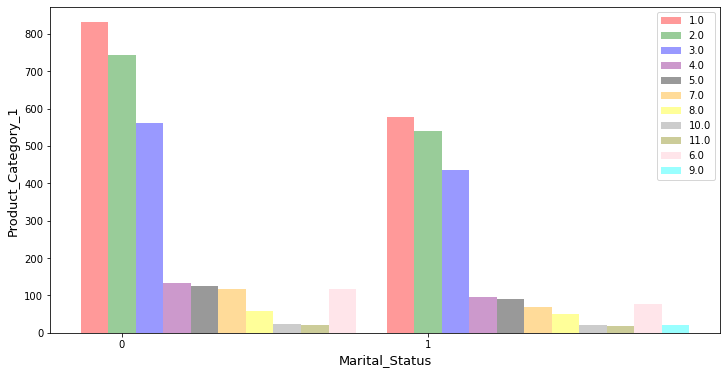

In [590]:
fig,ax=plt.subplots(figsize=(12,6))
bar_width=0.09
index=np.arange(2)

b1=plt.bar(index,final_df[1.0],bar_width,alpha=0.4,color='red',label='1.0')
b2=plt.bar(index+bar_width,final_df[2.0],bar_width,alpha=0.4,color='green',label='2.0')
b3=plt.bar(index+bar_width*2,final_df[3.0],bar_width,alpha=0.4,color='blue',label='3.0')
b4=plt.bar(index+bar_width*3,final_df[4.0],bar_width,alpha=0.4,color='purple',label='4.0')
b5=plt.bar(index+bar_width*4,final_df[5.0],bar_width,alpha=0.4,color='black',label='5.0')
b6=plt.bar(index+bar_width*5,final_df[7.0],bar_width,alpha=0.4,color='orange',label='7.0')
b7=plt.bar(index+bar_width*6,final_df[8.0],bar_width,alpha=0.4,color='yellow',label='8.0')
b8=plt.bar(index+bar_width*7,final_df[10.0],bar_width,alpha=0.4,color='gray',label='10.0')
b9=plt.bar(index+bar_width*8,final_df[11.0],bar_width,alpha=0.4,color='olive',label='11.0')
b10=plt.bar(index+bar_width*9,final_df[6.0],bar_width,alpha=0.4,color='pink',label='6.0')
b11=plt.bar(index+bar_width*10,final_df[9.0],bar_width,alpha=0.4,color='cyan',label='9.0')

plt.xticks(np.arange(bar_width,2+bar_width,1),[0,1])
plt.xlabel('Marital_Status',size=13)
plt.ylabel('Product_Category_1',size=13)
plt.legend()
plt.show()
#결혼을 안했을때 6,3그룹의 구매가 더 많음 
#9그룹의 구매는 결혼한 사람에게 몰려있음 


# purchase

In [591]:
df['Purchase'].value_counts()

7001     6
7063     6
5328     6
8115     6
7176     5
        ..
12069    1
16668    1
3187     1
4043     1
1413     1
Name: Purchase, Length: 3736, dtype: int64

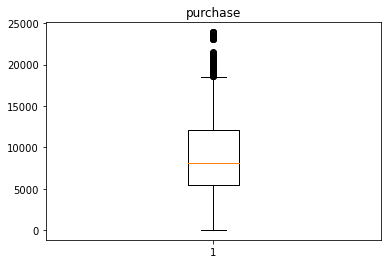

In [592]:
#연속형 변수이므로 boxplot을 그려보자 

import matplotlib.pyplot as plt
plt.boxplot(df['Purchase'],whis=1.0)
plt.title('purchase')
plt.show()

In [593]:
out=outliers_iqr(df,'Purchase')
out #총 434개의 이상치 

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
10,1001088,P00278242,F,0-17,NaN,A,3,0,1.0,NaN,NaN,18964
25,1001926,P00087042,F,0-17,0.0,B,1,0,10.0,14.0,16.0,23866
26,1004606,P00370293,F,0-17,NaN,B,2,0,NaN,NaN,NaN,37
53,1000019,P00113142,M,0-17,NaN,A,3,0,1.0,5.0,12.0,19306
77,1004541,P00145042,M,0-17,NaN,B,1,0,1.0,2.0,5.0,18974
...,...,...,...,...,...,...,...,...,...,...,...,...
4953,1004885,P00110942,M,55+,1.0,C,1,0,1.0,2.0,NaN,19313
4960,1001887,P00177442,M,55+,NaN,C,3,1,1.0,6.0,8.0,19007
4965,1002656,P00371644,M,55+,NaN,C,2,1,NaN,NaN,NaN,130
4972,1005541,P00052842,M,55+,7.0,C,1,0,10.0,15.0,NaN,23247


In [594]:
df.loc[out.index,"Pruchase"]=None
df['Purchase']=df['Purchase'].fillna(df['Purchase'].mean()) #결측치 평균값으로 채우기 

In [595]:
df['Purchase'].value_counts()

7001     6
7063     6
5328     6
8115     6
7176     5
        ..
12069    1
16668    1
3187     1
4043     1
1413     1
Name: Purchase, Length: 3736, dtype: int64

# 전체 데이터확인 

In [596]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4288 non-null   float64
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4769 non-null   float64
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
 12  Pruchase                    0 non-null      float64
dtypes: float64(5), int64(3), object(5

In [597]:
df=df.loc[:,['Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status','Product_Category_1']]
df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1
0,F,0-17,NaN,A,3,0,5.0
1,F,0-17,NaN,A,1,0,7.0
2,F,0-17,NaN,A,1,0,1.0
3,F,0-17,NaN,A,3,0,2.0
4,F,0-17,NaN,A,3,0,3.0
...,...,...,...,...,...,...,...
4993,M,55+,7.0,C,1,1,1.0
4994,M,55+,1.0,C,1,1,8.0
4995,M,55+,NaN,C,3,1,1.0
4996,M,55+,0.0,C,2,1,12.0


In [598]:
df=pd.get_dummies(data=df,columns=['Gender'])
df=pd.get_dummies(data=df,columns=['Age'])
df=pd.get_dummies(data=df,columns=['Occupation'])
df=pd.get_dummies(data=df,columns=['City_Category'])
df

,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-55,...,Occupation_6.0,Occupation_7.0,Occupation_12.0,Occupation_14.0,Occupation_16.0,Occupation_17.0,Occupation_20.0,City_Category_A,City_Category_B,City_Category_C
0,3,0,5.0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,7.0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,1.0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,0,2.0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3,0,3.0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,1,1,1.0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4994,1,1,8.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4995,3,1,1.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4996,2,1,12.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [599]:
df=df.dropna()

In [600]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4769 entries, 0 to 4997
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Stay_In_Current_City_Years  4769 non-null   object 
 1   Marital_Status              4769 non-null   int64  
 2   Product_Category_1          4769 non-null   float64
 3   Gender_F                    4769 non-null   uint8  
 4   Gender_M                    4769 non-null   uint8  
 5   Age_0-17                    4769 non-null   uint8  
 6   Age_18-25                   4769 non-null   uint8  
 7   Age_26-35                   4769 non-null   uint8  
 8   Age_36-45                   4769 non-null   uint8  
 9   Age_46-55                   4769 non-null   uint8  
 10  Age_55+                     4769 non-null   uint8  
 11  Occupation_0.0              4769 non-null   uint8  
 12  Occupation_1.0              4769 non-null   uint8  
 13  Occupation_2.0              4769 

# 모델링 

In [601]:
y_data=df.loc[:,['Product_Category_1']]

In [602]:
columns=df.columns.difference(['Product_Category_1'])

x_data=df[columns]

In [603]:
x_data.info() #stay_in_current_ciry_years는 문자형이므로 바꾸어주자. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4769 entries, 0 to 4997
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age_0-17                    4769 non-null   uint8 
 1   Age_18-25                   4769 non-null   uint8 
 2   Age_26-35                   4769 non-null   uint8 
 3   Age_36-45                   4769 non-null   uint8 
 4   Age_46-55                   4769 non-null   uint8 
 5   Age_55+                     4769 non-null   uint8 
 6   City_Category_A             4769 non-null   uint8 
 7   City_Category_B             4769 non-null   uint8 
 8   City_Category_C             4769 non-null   uint8 
 9   Gender_F                    4769 non-null   uint8 
 10  Gender_M                    4769 non-null   uint8 
 11  Marital_Status              4769 non-null   int64 
 12  Occupation_0.0              4769 non-null   uint8 
 13  Occupation_1.0              4769 non-null   uint

In [604]:
x_data=x_data.replace({'Stay_In_Current_City_Years':'4+'},4).astype('int')

In [605]:
y_data.isna().sum()

Product_Category_1    0
dtype: int64

In [606]:
#knn은 target데이터는 필요없으므로 훈련, 테스트만 나누어주자
from sklearn.model_selection import train_test_split
train_input,test_input,train_target,test_target=train_test_split(x_data,y_data,test_size=0.2,random_state=1)
print(train_input.shape,train_target.shape)
print(test_input.shape,test_target.shape)

(3815, 25) (3815, 1)
(954, 25) (954, 1)


In [610]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier(n_neighbors=6,weights='uniform')
clf.fit(train_input,train_target)
pred=clf.predict(test_input)

C:\Users\diaky\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [611]:
from sklearn.metrics import confusion_matrix,accuracy_score
test_cm=confusion_matrix(test_target,pred)
test_acc=accuracy_score(test_target,pred)


print(test_cm)
print('\n')
print('정확도:',test_acc)



[[111   9   5   2  82   9   2  37   0   4   0   0]
 [ 21   1   1   1  14   0   0   7   0   0   0   0]
 [ 13   5   2   0  10   1   0   7   0   2   0   0]
 [ 10   1   3   1   3   1   0   0   0   0   0   0]
 [118   4   5   3  94   5   0  43   0   4   0   0]
 [ 16   2   0   0  14   0   0   4   0   1   0   0]
 [  1   1   0   0   2   0   1   0   0   0   0   0]
 [ 90   9   3   0  55   2   0  44   0   1   0   0]
 [  4   0   1   0   3   0   0   1   0   0   0   0]
 [ 14   4   2   0  12   1   0   7   0   2   0   0]
 [  1   0   0   0   4   0   0   0   0   0   0   0]
 [  5   1   1   0   2   0   0   2   0   0   0   0]]


정확도: 0.26834381551362685


In [615]:
from sklearn.model_selection import GridSearchCV
knn=KNeighborsClassifier(weights='uniform')
paramas={'n_neighbors':[i for i in range(1,20,2)],"p":[1,2]}
gs=GridSearchCV(knn,paramas,n_jobs=-1)
gs.fit(train_input,train_target)
dt=gs.best_estimator_
print(dt)
print(dt.score(train_input,train_target))
#그리드 서치 최적의 파라미터와 교차검증결과 정확도 0.37까지 상승..

C:\Users\diaky\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\diaky\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=19)
0.37378768020969855
